In [1]:
import numpy
import pandas
import sklearn.svm
import sklearn.cluster
import sklearn.metrics
import matplotlib.pyplot
import sklearn.model_selection

In [2]:
init_df = pandas.read_csv('winequality-red.csv', sep=',')

In [3]:
x = pandas.concat([init_df.iloc[:, :8], init_df.iloc[:, 9:]], axis=1, join='inner')
y = init_df['pH']

In [4]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25)

In [5]:
kmeans_train_source, kmeans_predict_source, kmeans_train_target, kmeans_remove_target = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.33)

In [6]:
distortions = []
k = 10
clustering = None

In [7]:
for i in range(1, k):
    clustering = sklearn.cluster.KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    clustering.fit(kmeans_train_source)
    distortions.append(clustering.inertia_)

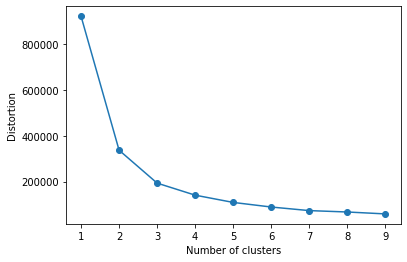

In [8]:
# plot
matplotlib.pyplot.plot(range(1, k), distortions, marker='o')
matplotlib.pyplot.xlabel('Number of clusters')
matplotlib.pyplot.ylabel('Distortion')
matplotlib.pyplot.show()

In [9]:
means_array = numpy.zeros(9, dtype=numpy.int64)

In [10]:
means_dict = dict(enumerate(means_array))

In [11]:
for i in range(len(clustering.predict(kmeans_train_source))):
    x = kmeans_train_target.iloc[i]
    means_dict[clustering.predict(kmeans_train_source)[i]] = means_dict[clustering.predict(kmeans_train_source)[i]] + x

In [12]:
means_df = pandas.DataFrame.from_dict(list(means_dict.items())).drop([0], axis=1)

In [13]:
unique, counts = numpy.unique(clustering.predict(kmeans_train_source), return_counts=True)

In [14]:
mean_denominators = dict(zip(unique, counts))

In [15]:
def getList(dict):
    return [*dict]

In [16]:
for i in getList(mean_denominators):
    means_df.iloc[i][1] = round(means_df.iloc[i]/mean_denominators.get(i), 2).item()

In [17]:
means_df = means_df.rename(columns={1: "cluster_means"})

In [18]:
y_pred = pandas.DataFrame(index=kmeans_remove_target.index, columns=['pH'])

In [19]:
for i in range(len(clustering.predict(kmeans_predict_source))):
    y_pred.iloc[i] = means_df.loc[clustering.predict(kmeans_predict_source)[i]].item()

In [20]:
variance = round(abs(sum(kmeans_remove_target.to_numpy() - y_pred.to_numpy().flatten()))/len(kmeans_remove_target), 3)

In [21]:
train_dataset = pandas.concat([kmeans_train_source, kmeans_train_target], axis=1, sort=False)

In [22]:
test_dataset = pandas.concat([kmeans_predict_source, y_pred], axis=1, sort=False)

In [23]:
first_split = pandas.concat([train_dataset, test_dataset], axis=0, sort=False)

In [24]:
x_train = pandas.concat([first_split.iloc[:, :10], first_split.iloc[:, 11:]], axis=1, join='inner')

In [25]:
y_train = first_split.iloc[:, 10]

In [26]:
svm_clf = sklearn.svm.SVC(gamma=0.01, C=1000, kernel='rbf')
svm_clf.fit(x_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [27]:
tmp = y_test

In [28]:
y_test = x_test.iloc[:, 10]

In [29]:
x_test = pandas.concat([x_test.iloc[:, :10], tmp], axis=1, join='inner')

In [30]:
y_pred = svm_clf.predict(x_test)

In [31]:
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00        15
           5       0.66      0.66      0.66       171
           6       0.56      0.61      0.59       160
           7       0.54      0.44      0.48        48
           8       0.00      0.00      0.00         6

    accuracy                           0.58       400
   macro avg       0.29      0.29      0.29       400
weighted avg       0.57      0.58      0.58       400



/home/andreas/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
